# TVOC Measurement Analysis
### Using the TVOC Maximum Dataset

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [4]:
df = pd.read_excel('TVOC_max_KK.xlsx')

In [5]:
df = df.drop(columns=['Unnamed: 8', 'Unnamed: 9'])

### Data overview
 - There are 688 individual projects
 - Around 20 projects have over 2000 reading entries
 - Around 135 projects only have 1 reading entry
 - 14 different partners measure TVOC
 - The maximum reading is 60,000 ug/m3 from a project with the partner Idun

In [6]:
number_readings = df.groupby('leed_Id')['reading'].count().sort_values(ascending=False).reset_index(name="count")

### There are a few partners with similar names or collaborations:

Arbnco is grouped by the following:
 - arbnwell/Arbnco
 - arbnwell
 - arbnwell data push integration
 - arbnwell data push integration/Arbnco
 
BEE is grouped by:
- BEE
- BEE/Qlear

Idun is grouped by the following:
- idun-local-certify-api
- idun-prod-certify-api

QLEAR is grouped by:
- QLEAR/Qlear
- QLEAR

Wattics is grouped by the following:
- Wattics Energy Analytics
- Wattics Energy Analytics/Qlear

FGB is FGB 

Other consists of:
- Tishman Speyer Live
- USGBC Tridiuum
- WatchWire
- Abacus
- Commutifi
- EPL OAUTH2
- SLB
- SLB_Arc_Datalake_Prod
- Bractlet Intelligence Platform - LIVE

In [7]:
len(df['partner'].unique())
#deleting test APP
df = df[df['partner'] != 'test APP']

In [8]:
df['partner_group'] = df['partner'].str.lower().str.split('/').str[0].str.strip()
# Mapping representative names for each group
partner_mapping  = {
    'abacus': 'Abacus',
    'Abacus': 'Abacus',
    'arbnwell': 'Arbnco',
    'arbnwell data push integration': 'Arbnco',
    'bee': 'BEE',
    'bractlet intelligence platform - live': 'Bractlet',
    'commutifi': 'Commutifi',
    'epl oauth2': 'EPL OAUTH2',
    'fgb': 'FGB',
    'idun-local-certify-api': 'Idun',
    'idun-prod-certify-api' : 'Idun',
    'qlear': 'QLEAR',
    'slb': 'SLB',
    'slb_arc_datalake_prod': 'SLB',
    'tishman speyer live': 'Tishman Speyer',
    'usgbc tridiuum': 'Tridium',
    'watchwire': 'WatchWire',
    'wattics energy analytics': 'Wattics',
    'Wattics Energy Analytics':'Wattics'
}

df['partner_group'] = df['partner_group'].map(partner_mapping)

In [10]:
other_mapping = {
    'Abacus': 'Other',
    'Arbnco': 'Arbnco',
    'BEE': 'BEE',
    'Bractlet': 'Other',
    'Commutifi': 'Other',
    'EPL OAUTH2': 'Other',
    'FGB': 'FGB',
    'Idun': 'Idun',
    'QLEAR': 'QLEAR',
    'SLB': 'Other',
    'Tishman Speyer': 'Other',
    'Tridium': 'Other',
    'WatchWire': 'Other',
    'Wattics': 'Wattics'
}
df['other_group'] = df['partner_group'].map(other_mapping)

In [12]:
partner_projects = df.groupby('partner_group')['leed_Id'].count().sort_values(ascending=False).reset_index(name="count")
other_projects = df.groupby('other_group')['leed_Id'].count().sort_values(ascending=False).reset_index(name="count")

## 1.  Exploratory Analysis

In [17]:
arbnco = df[df['partner_group'] == 'Arbnco'].copy()
bee = df[df['partner_group'] == 'BEE'].copy()
fgb = df[df['partner_group'] == 'FGB'].copy()
idun = df[df['partner_group'] == 'Idun'].copy()
qlear = df[df['partner_group'] == 'QLEAR'].copy()
wattics = df[df['partner_group'] == 'Wattics'].copy()
other = df[df['other_group']=='Other'].copy()

### 1a. Boxplots of TVOC Measurements from Highest to Lowest Medians

It's so difficult to see the boxplots given Arbnco and Idun's high values.

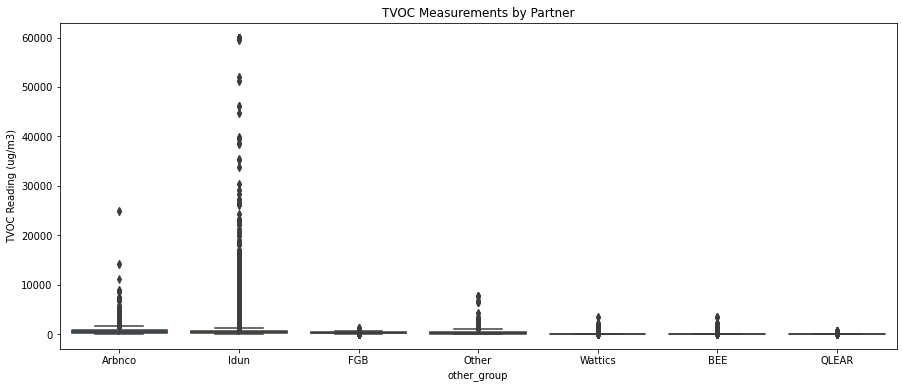

In [13]:
medians = df.groupby('other_group')['reading'].median().sort_values(ascending=False)
x_order = medians.index
plt.figure(figsize=(15, 6))
sns.boxplot(x=df['other_group'], y=df['reading'],order=x_order)
plt.ylabel('TVOC Reading (ug/m3)')
plt.title('TVOC Measurements by Partner')
plt.show()

#### Setting the y-axis limit to 5000 ug/m3 which is already 10 times more than the threshold, we can get a better sense of medians across different partners.

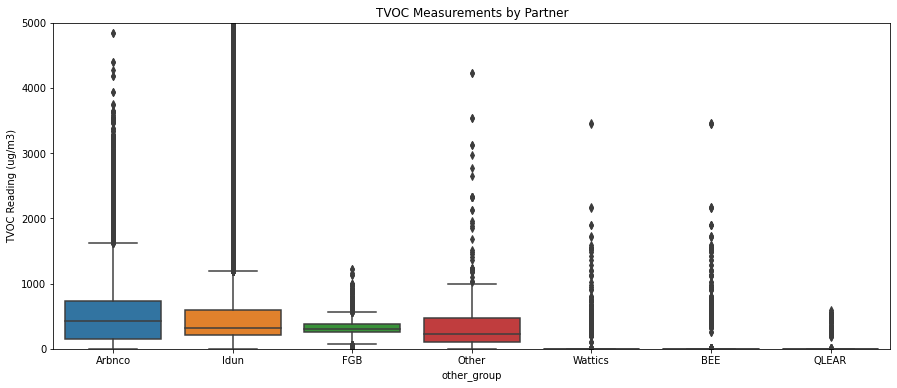

In [14]:
medians = df.groupby('other_group')['reading'].median().sort_values(ascending=False)
x_order = medians.index
plt.figure(figsize=(15, 6))
sns.boxplot(x=df['other_group'], y=df['reading'],order=x_order)
plt.ylabel('TVOC Reading (ug/m3)')
plt.title('TVOC Measurements by Partner')
plt.ylim(top=5000,bottom=0)  # Set the x-axis limit to 5000
plt.show()


#### Lastly, to really look at Wattics, BEE, and QLEAR, the maximum was cut off at 1000 ug/m3. Given the shape of the last three partners, the medians are 0.

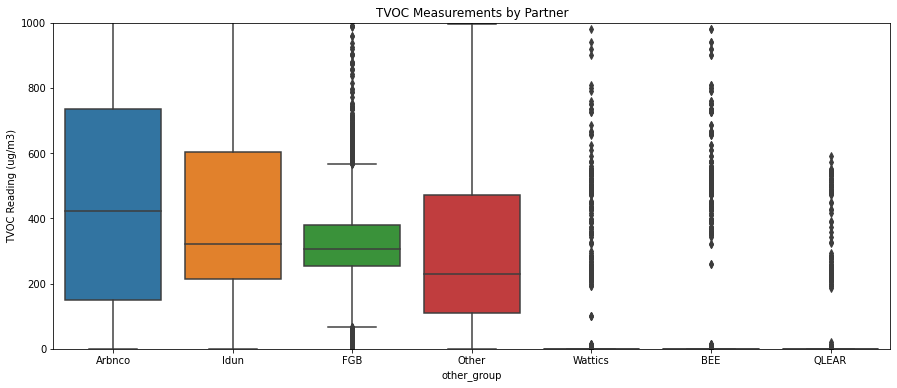

In [15]:
medians = df.groupby('other_group')['reading'].median().sort_values(ascending=False)
x_order = medians.index
plt.figure(figsize=(15, 6))
sns.boxplot(x=df['other_group'], y=df['reading'],order=x_order)
plt.ylabel('TVOC Reading (ug/m3)')
plt.title('TVOC Measurements by Partner')
plt.ylim(top=1000,bottom=0)  # Set the x-axis limit to 5000
plt.show()

#### 1b. Median Maximum TVOC Reading for each Partner:

In [29]:
medians = df.groupby('other_group')['reading'].median().sort_values(ascending=False)
for partner, median in medians.items():
    rounded_median = round(median,1)
    print(f"{partner}: {rounded_median}")

Arbnco: 424.0
Idun: 322.3
FGB: 307.0
Other: 229.0
Wattics: 0.2
BEE: 0.2
QLEAR: 0.2


Just by observing the differences in medians and the boxplots we can see both the great spread and high values of TVOC associated with Arbnco.

## 2. Outlier Removal and Field Museum

In [39]:
import numpy as np
#these contain the dfs of the outliers themselves
# Method 1: Z-Score
z_scores = stats.zscore(df['reading'])
z_score_threshold = 3
z_score_outliers = df['reading'][np.abs(z_scores) > z_score_threshold]
z_score_outliers = pd.DataFrame(z_score_outliers, columns=['reading'])

# Method 2: IQR
Q1 = df['reading'].quantile(0.25)
Q3 = df['reading'].quantile(0.75)
IQR = Q3 - Q1
iqr_threshold = 1.5
iqr_outliers = df['reading'][(df['reading'] < Q1 - iqr_threshold * IQR) | (df['reading'] > Q3 + iqr_threshold * IQR)]
iqr_outliers = pd.DataFrame(iqr_outliers, columns=['reading'])


# Method 3: Isolation Forest
isolation_forest = IsolationForest(contamination='auto')
isolation_forest.fit(df['reading'].values.reshape(-1, 1))
isolation_outliers = df['reading'][isolation_forest.predict(df['reading'].values.reshape(-1, 1)) == -1]
isolation_outliers = pd.DataFrame(isolation_outliers, columns=['reading'])

#these are the dfs after removal
z_score_outliers_removed = df[np.abs(z_scores) <= z_score_threshold]
iqr_outliers_removed = df[(df['reading'] >= Q1 - 1.5 * IQR) & (df['reading'] <= Q3 + 1.5 * IQR)]
isolation_outliers_removed = df.drop(isolation_outliers.index)

## 2a. Using Z-score, Interquartile Range, and Isolation Forest Outlier Removal Methods, we can see the treatment of each one

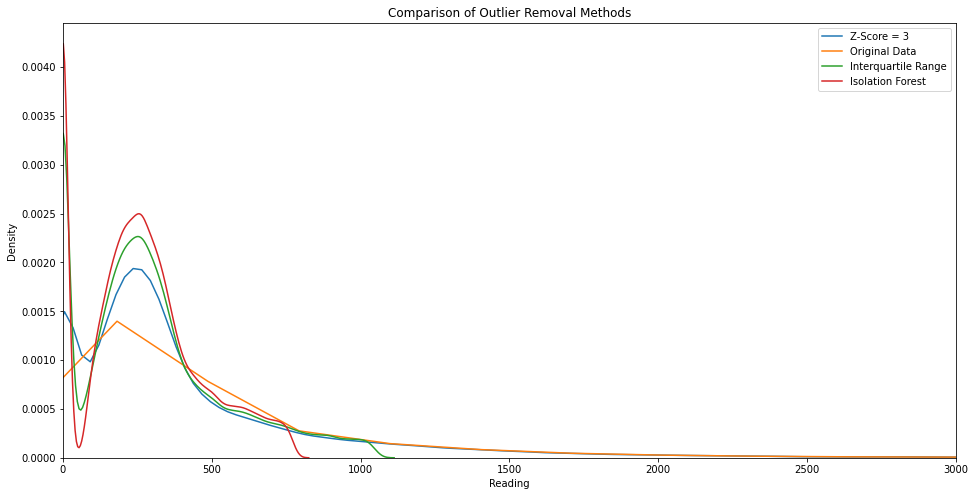

In [136]:
min_value = 0
max_value = 3000

fig, ax = plt.subplots(figsize=(16, 8))

sns.kdeplot(z_score_outliers_removed['reading'], label='Z-Score = 3', ax=ax)
sns.kdeplot(df['reading'], label='Original Data', ax=ax)
sns.kdeplot(iqr_outliers_removed['reading'], label='Interquartile Range', ax=ax)
sns.kdeplot(isolation_outliers_removed['reading'], label='Isolation Forest', ax=ax)

ax.set_xlim(min_value, max_value)
ax.set_ylim(0, None) 

ax.set_xlabel('Reading')
ax.set_ylabel('Density')
ax.set_title('Comparison of Outlier Removal Methods')


ax.legend()
plt.show()


## 2b. Field Museum Readings

In [64]:
fm = df.loc[df['leed_Id'] == 1000034946]

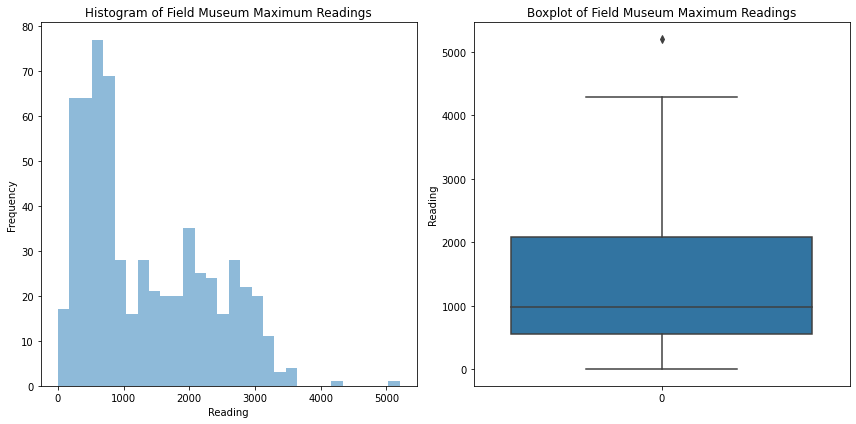

In [81]:
# leed_id = 1000034946
subset_reading = df.loc[df['leed_Id'] == 1000034946, 'reading']
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#histogram
axs[0].hist(subset_reading, bins=30, alpha=0.5)
axs[0].set_xlabel('Reading')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Field Museum Maximum Readings')

# Plot boxplot 
sns.boxplot(data=[subset_reading], ax=axs[1])
axs[1].set_ylabel('Reading')
axs[1].set_title('Boxplot of Field Museum Maximum Readings')


plt.tight_layout()
plt.show()


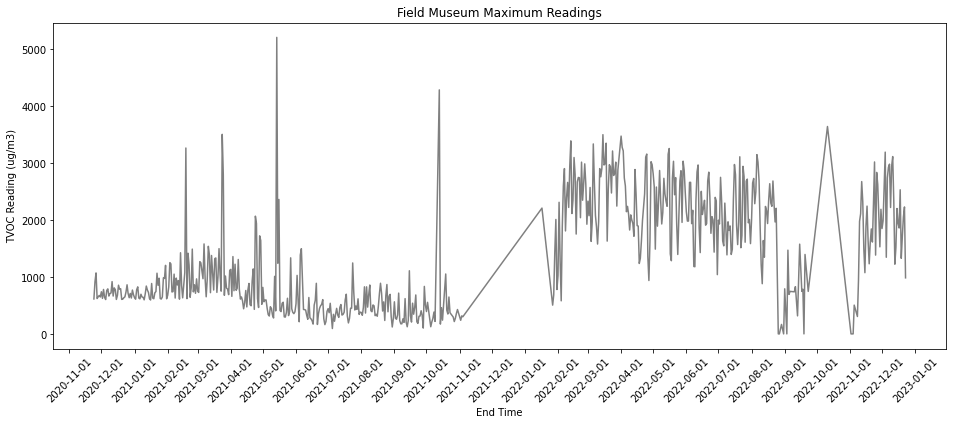

In [92]:
import matplotlib.dates as mdates

subset_end_time = pd.to_datetime(subset_end_time)

#df['leed_Id'] is 1000034946
subset_reading = df.loc[df['leed_Id'] == 1000034946, 'reading']

# Create a figure and axes
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(subset_end_time, subset_reading, linestyle='-', color='gray')
ax.set_xlabel('End Time')
ax.set_ylabel('TVOC Reading (ug/m3)')
ax.set_title('Field Museum Maximum Readings')


ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()


In [148]:

# Subset for leed_Id = 1000034946
subset_leed = df[df['leed_Id'] == 1000034946]

# Subset for arbnco without leed_Id = 1000034946
subset_arbnco = df[(df['partner_group'] == 'Arbnco') & (df['leed_Id'] != 1000034946)]

# Subset for all readings without leed_Id = 1000034946
subset_all = df[df['leed_Id'] != 1000034946]

table_data = {
    'Data': ['Field Museum', 'All Other Arbnco Readings', 'All Other Readings'],
    'Median': [subset_leed['reading'].median(), subset_arbnco['reading'].median(), subset_all['reading'].median()],
    'Average': [subset_leed['reading'].mean(), subset_arbnco['reading'].mean(), subset_all['reading'].mean()]
}

table_df = pd.DataFrame(table_data)

table_df = table_df.round(1)

print(table_df)


                        Data  Median  Average
0               Field Museum   973.7   1332.1
1  All Other Arbnco Readings   350.2    557.6
2         All Other Readings   279.5    499.7


## 2c. Z-Score Threshold Differences
The thresholds in this context refer to the z-score threshold values used to identify outliers in the data.

The z-score is a statistical measure that quantifies how many standard deviations an observation or data point is away from the mean of a distribution. By calculating the z-score for each data point, we can assess how unusual or extreme that data point is compared to mean of the data. The z-score for each data point represents its distance from the mean in terms of standard deviations.

A lower z-score represents higher strictness when identifying outliers. This cutoff is based on what is considered an unusual datapoint based on its distance from the mean. 




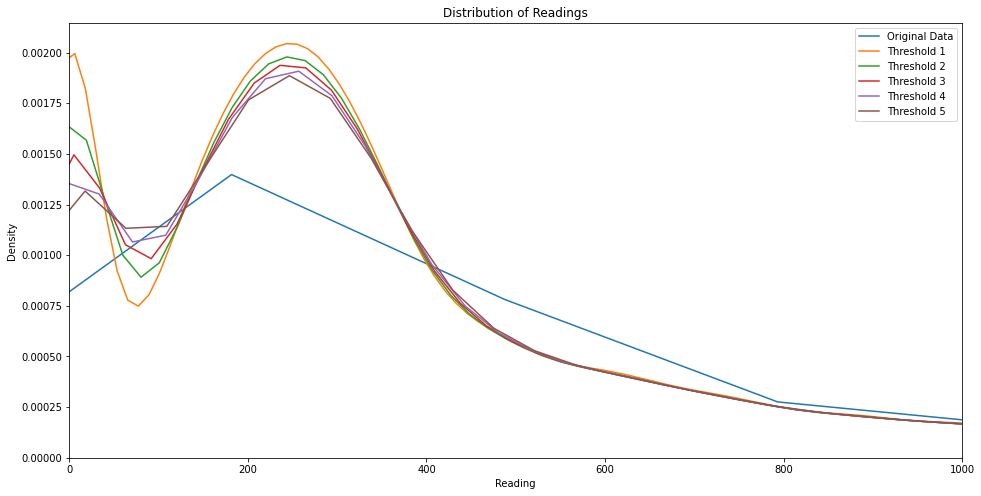

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the original data
sns.kdeplot(data=df['reading'], label='Original Data', shade=False, ax=ax)

# Iterate over different z-score threshold values
for threshold in range(1, 6):
    # Filter non-outlier values
    non_outliers = df['reading'][np.abs(z_scores) <= threshold]
    
    # Create a KDE plot for the non-outlier values
    sns.kdeplot(data=non_outliers, label=f'Threshold {threshold}', shade=False, ax=ax)

plt.title("Distribution of Readings")
plt.xlabel("Reading")
ax.set_xlim(0, 1000)
plt.ylabel("Density")
ax.set_ylim(0, None)
plt.legend()
plt.show()


### Other parts I could not get to just yet:



|Dataset Used|T_stat|P_stat|Cohen's d|Confidence Interval|
|---|---|---|---|---|
|Dataset|10.9|1.95e-27|0.11|   |
|Z-score|19.7|3.3e-27|0.31|(172.2, 210.3)|
|IRQ|16.1|6.3e-57|0.26| (60.5, 77.3)|

### I'm picking the z_score method for now as it removes the least number of outliers. Isolation forest method is probably a no-go anyway. 

In [41]:
# Calculate z-scores
z_scores = stats.zscore(df['reading'])
z_score_threshold = 3
df_zscore = df[np.abs(z_scores) <= z_score_threshold]
arbnco_data = df_zscore[df_zscore['partner'].isin(arbnco_aliases)]
other_partners_data = df_zscore[~df_zscore['partner'].isin(arbnco_aliases)]
t_stat, p_value = stats.ttest_ind(arbnco_data['reading'], other_partners_data['reading'], equal_var=False)

if p_value < 0.05:
    print("Arbnco's TVOC measurements (after removing outliers) are statistically significantly higher than the rest of the partners.")
else:
    print("Arbnco's TVOC measurements (after removing outliers) are not statistically significantly higher than the rest of the partners.")

print("Mean TVOC for Arbnco:", arbnco_data['reading'].mean())
print("Mean TVOC for other partners:", other_partners_data['reading'].mean())

print("t-statistic:", t_stat)
print("p-value:", p_value)

Arbnco's TVOC measurements (after removing outliers) are statistically significantly higher than the rest of the partners.
Mean TVOC for Arbnco: 614.7350278752793
Mean TVOC for other partners: 423.5129519542787
t-statistic: 19.665053866094624
p-value: 3.301827077580284e-83


### Even after removing the outliers, the mean TVOC for Arbnco vs other partners is still statistically significantly higher.

Effect Size (Cohen's d):
This quantifies the magnitude or strength of the difference between Arbnco's TVOC measurements and the rest of the partners. Cohen's d is calculated by dividing the difference in means between the two groups by the pooled standard deviation. It provides a standardized measure of the effect, allowing for comparisons across different studies or variables.
Interpreting Cohen's d:
A small effect size (d ≈ 0.2) suggests a relatively small difference between the groups of partners.
A medium effect size (d ≈ 0.5) indicates a moderate difference.
A large effect size (d ≈ 0.8 or higher) signifies a substantial difference.
For example, if Cohen's d is calculated as 0.5, it suggests that Arbnco's TVOC measurements, on average, are half a standard deviation higher than the rest of the partners.

In [42]:
from scipy import stats

# Calculate effect size (Cohen's d)
mean_diff = arbnco_data['reading'].mean() - other_partners_data['reading'].mean()
pooled_std = np.sqrt((arbnco_data['reading'].std()**2 + other_partners_data['reading'].std()**2) / 2)
effect_size = mean_diff / pooled_std

print("Effect size (Cohen's d):", effect_size)


Effect size (Cohen's d): 0.30832576971509157


The effect size is 0.3 which is in between small and medium effect size. There could be anywhere between small and moderate difference

### Confidence Intervals
Confidence intervals provide a range of plausible values for the population parameter (in this case, the mean difference between Arbnco and the other partners' TVOC measurements). A 95% confidence interval, as used in the example, means that if we were to repeat the study multiple times and calculate confidence intervals, we would expect the true population mean difference to fall within the computed interval in approximately 95% of the cases.

If the confidence interval does not include zero, it suggests that the mean difference is statistically significant at the chosen significance level (e.g., 0.05). This indicates that there is evidence of a significant difference between Arbnco and the other partners.
If the confidence interval includes zero, it suggests that the mean difference is not statistically significant, and we cannot conclude that there is a significant difference between Arbnco and the other partners.
For example, a 95% confidence interval of (0.1, 0.3) would indicate that we can be 95% confident that the true mean difference in TVOC measurements between Arbnco and the other partners falls within the range of 0.1 to 0.3 units.

In [43]:
# Calculate confidence intervals
mean_diff = arbnco_data['reading'].mean() - other_partners_data['reading'].mean()
std_diff = np.sqrt((arbnco_data['reading'].std()**2 / len(arbnco_data)) + (other_partners_data['reading'].std()**2 / len(other_partners_data)))
confidence_interval = stats.t.interval(0.95, len(df_filtered)-1, loc=mean_diff, scale=std_diff)

print("Confidence Interval (95%):", confidence_interval)


Confidence Interval (95%): (172.16336438565867, 210.28078745634258)


So this means that the a 95% confidence interval of (172.16336438565867, 210.28078745634258) has a lower and upper bound of 172 and 211 difference in measurements higher than the mean.

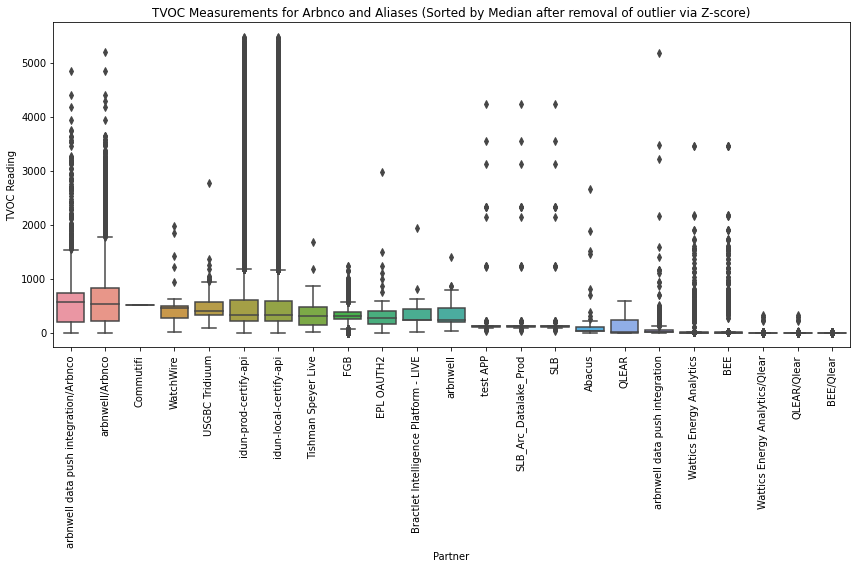

In [52]:
median_readings = df_zscore.groupby('partner')['reading'].median().sort_values(ascending=False)
partner_order = median_readings.index

plt.figure(figsize=(12, 8))
sns.boxplot(x='partner', y='reading', data=df_zscore, order=partner_order)
plt.xlabel('Partner')
plt.ylabel('TVOC Reading')
plt.title('TVOC Measurements for Arbnco and Aliases (Sorted by Median after removal of outlier via Z-score)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


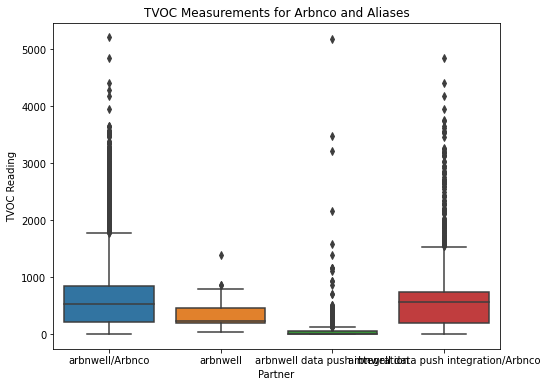

In [44]:
# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='partner', y='reading', data=df_zscore[df_zscore['partner'].isin(arbnco_aliases)])
plt.xlabel('Partner')
plt.ylabel('TVOC Reading')
plt.title('TVOC Measurements for Arbnco and Aliases')
plt.show()


### Using IQR outlier method
I'm going to do the same analysis but using the IQR method instead of z_score

In [46]:
Q1 = df['reading'].quantile(0.25)
Q3 = df['reading'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_iqr = df[(df['reading'] >= lower_bound) & (df['reading'] <= upper_bound)]

arbnco_data = df_iqr[df_iqr['partner'].isin(arbnco_aliases)]
other_partners_data = df_iqr[~df_iqr['partner'].isin(arbnco_aliases)]

t_stat, p_value = stats.ttest_ind(arbnco_data['reading'], other_partners_data['reading'], equal_var=False)

print("Mean TVOC for Arbnco:", arbnco_data['reading'].mean())
print("Mean TVOC for other partners:", other_partners_data['reading'].mean())

print("t-statistic:", t_stat)
print("p-value:", p_value)

Mean TVOC for Arbnco: 363.26666909817766
Mean TVOC for other partners: 294.381099015809
t-statistic: 16.124444533843192
p-value: 6.251629938121122e-57


Cohen's d: Effect size has decreased a little bit from the z_score method at ~0.26


In [47]:
# Calculate effect size (Cohen's d)
mean_diff = arbnco_data['reading'].mean() - other_partners_data['reading'].mean()
pooled_std = np.sqrt((arbnco_data['reading'].std()**2 + other_partners_data['reading'].std()**2) / 2)
effect_size = mean_diff / pooled_std

print("Effect size (Cohen's d):", effect_size)


Effect size (Cohen's d): 0.2631094174070508


Confidence Interval

In [48]:
# Calculate confidence intervals
mean_diff = arbnco_data['reading'].mean() - other_partners_data['reading'].mean()
std_diff = np.sqrt((arbnco_data['reading'].std()**2 / len(arbnco_data)) + (other_partners_data['reading'].std()**2 / len(other_partners_data)))
confidence_interval = stats.t.interval(0.95, len(df_filtered)-1, loc=mean_diff, scale=std_diff)

print("Confidence Interval (95%):", confidence_interval)

Confidence Interval (95%): (60.512318450813936, 77.25882171392335)


So this means that the a 95% confidence interval of (60.512318450813936, 77.25882171392335) has a lower and upper bound of 60 and 78 difference in measurements higher than the mean.

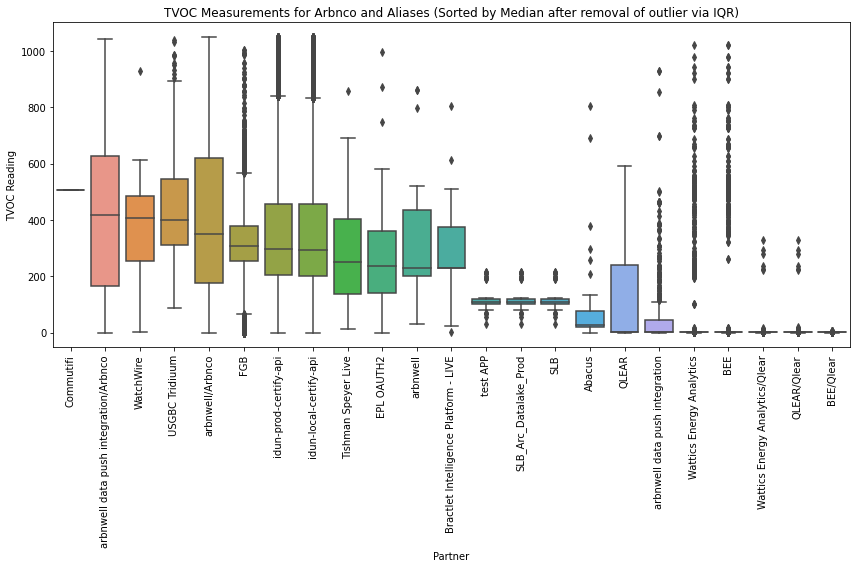

In [39]:
median_readings = df_iqr.groupby('partner')['reading'].median().sort_values(ascending=False)

partner_order = median_readings.index

plt.figure(figsize=(12, 8))
sns.boxplot(x='partner', y='reading', data=df_iqr, order=partner_order)
plt.xlabel('Partner')
plt.ylabel('TVOC Reading')
plt.title('TVOC Measurements for Arbnco and Aliases (Sorted by Median after removal of outlier via IQR)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Preliminary Results
T-statistic:
The t-statistic measures the difference between the means of Arbnco's TVOC readings and the rest of the partners, relative to the variability within the groups. It is calculated as the difference in means divided by the standard error of the difference.
In this case, **the t-statistic value of 10.89 indicates a large difference between Arbnco's TVOC measurements and the rest of the partners.**

P-value:
The p-value represents the probability of observing a t-statistic as extreme as the one obtained in the sample data, assuming the null hypothesis is true. Here, the null hypothesis states that there is no difference between Arbnco's TVOC measurements and the rest of the partners.
The p-value you provided, 2.34e-27, is an extremely small value. This suggests strong evidence **against** the null hypothesis and indicates that the **observed difference between Arbnco and the other partners is statistically significant.**

With a very small p-value (e.g., less than 0.05), we can conclude that Arbnco's TVOC measurements are significantly different from the rest of the partners. The t-statistic value of 10.89 further supports this conclusion, indicating a substantial difference in TVOC measurements between Arbnco and the other partners. The results suggest that Arbnco's TVOC measurements are statistically significantly higher than the TVOC measurements of the other partners.

In [93]:
not_arbnco = df[df['partner_group'] != "Arbnco"]
t_stat, p_value = stats.ttest_ind(arbnco['reading'], not_arbnco['reading'], equal_var=False)

if p_value < 0.05:
    print("Arbnco's TVOC measurements are statistically significantly higher than the rest of the partners.")
else:
    print("Arbnco's TVOC measurements are not statistically significantly higher than the rest of the partners.")

# Printing mean values
print("Mean TVOC for Arbnco:", arbnco['reading'].mean())
print("Mean TVOC for other partners:", not_arbnco['reading'].mean())

# Printing t-statistic and p-value
print("t-statistic:", t_stat)
print("p-value:", p_value)

Arbnco's TVOC measurements are statistically significantly higher than the rest of the partners.
Mean TVOC for Arbnco: 647.9716502615969
Mean TVOC for other partners: 498.33681958091785
t-statistic: 10.904700739737589
p-value: 1.9530483318168347e-27


In [95]:
# Calculate effect size (Cohen's d)
mean_diff = arbnco['reading'].mean() - not_arbnco['reading'].mean()
pooled_std = np.sqrt((arbnco['reading'].std()**2 + not_arbnco['reading'].std()**2) / 2)
effect_size = mean_diff / pooled_std

print("Effect size (Cohen's d):", effect_size)

Effect size (Cohen's d): 0.10987123241346584
